**Amaç ve Kapsam**

Tanımlanan veri seti üzerinde konut fiyatlarının tahminlenmesi için Spark ML kütüphanesi kullanılarak
PySpark ile bir regresyon modeli oluşturulacaktır.


İlk olarak gerekli kütüphaneler import edilip SparkSession oluşturulur.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import count, when, isnan, col
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
spark = SparkSession.builder.appName("HousingPricePrediction").getOrCreate()

Daha sonra Kaggle'dan indirilen dataseti Colab'e yüklenir ve ham veriyi incelenir.

In [ ]:
file_path = "/content/california_housing.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

df.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

Veri setindeki sütunlar ve veri tipleri printSchema() fonksiyonu ile görüntülenir.

İstatistiksel özet bilgileri describe().show() ile görüntülenir.

Son olarak select("median_house_value").summary().show() fonksiyonu ile hedef değişkenin dağılımı görüntülenir.

In [ ]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [ ]:
df.describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|             20640|          20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           NULL|
| stddev|  2.0035317

In [ ]:
df.select("median_house_value").summary().show()

+-------+------------------+
|summary|median_house_value|
+-------+------------------+
|  count|             20640|
|   mean|206855.81690891474|
| stddev|115395.61587441359|
|    min|           14999.0|
|    25%|          119600.0|
|    50%|          179700.0|
|    75%|          264700.0|
|    max|          500001.0|
+-------+------------------+



Eksik veriler, modelin performansını olumsuz etkileyebilir.

Bu nedenle, eksik veriler tespit edilmiş ve temizlenmiştir

In [ ]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

df = df.na.drop()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



Modelde kullanılacak bağımsız değişkenler belirlenir ve makine öğrenmesi modellerinde girdileri tek bir vektör haline getirmek için VectorAssembler kullanılır.

In [ ]:
feature_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

df.select("features", "median_house_value").show(5)

+--------------------+------------------+
|            features|median_house_value|
+--------------------+------------------+
|[-122.23,37.88,41...|          452600.0|
|[-122.22,37.86,21...|          358500.0|
|[-122.24,37.85,52...|          352100.0|
|[-122.25,37.85,52...|          341300.0|
|[-122.25,37.85,52...|          342200.0|
+--------------------+------------------+
only showing top 5 rows



Veri seti, rastgele olarak %80 eğitim ve %20 test olacak şekilde ayrılır.

In [ ]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

Linear Regression, bağımlı ve bağımsız değişkenler arasındaki doğrusal ilişkiyi modellemek için kullanılan basit ve yorumlanabilir bir regresyon modelidir.

Bu model, özellikle veri setindeki ilişkilerin doğrusal olduğu durumlarda etkili sonuçlar verir.

In [ ]:
lr = LinearRegression(featuresCol="features", labelCol="median_house_value")
lr_model = lr.fit(train_data)
lr_train_predictions = lr_model.transform(train_data)
lr_test_predictions = lr_model.transform(test_data)

Farklı bir modelle karşılaştırma yapmak amacıyla Gradient Boosted Trees (GBT) Regressor modeli oluşturulmuştur.

GBTRegressor, doğrusal olmayan ilişkileri modellemede etkili bir ensemble yöntemidir ve Linear Regression modeline kıyasla daha karmaşık veri setlerinde yüksek doğruluk oranları sunar.

In [ ]:
gbt = GBTRegressor(featuresCol="features", labelCol="median_house_value")
gbt_model = gbt.fit(train_data)
gbt_train_predictions = gbt_model.transform(train_data)
gbt_test_predictions = gbt_model.transform(test_data)

RegressionEvaluator, modelin tahminleri ile gerçek değerleri karşılaştırarak RMSE ve R² gibi performans metriklerini hesaplar.

RMSE, tahmin hatalarının büyüklüğünü ölçerken, R² modelin veriyi ne kadar iyi açıkladığını gösterir.

Bu metrikler, modelin doğruluğunu ve başarımını değerlendirmek için kullanılır.

In [ ]:
evaluator_rmse = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")

Linear Regression için RMSE ve R² metrikleri hesaplanır.

In [ ]:
lr_train_rmse = evaluator_rmse.evaluate(lr_train_predictions)
lr_train_r2 = evaluator_r2.evaluate(lr_train_predictions)
lr_test_rmse = evaluator_rmse.evaluate(lr_test_predictions)
lr_test_r2 = evaluator_r2.evaluate(lr_test_predictions)

GBTRegressor için RMSE ve R² metrikleri hesaplanır.

In [ ]:
gbt_train_rmse = evaluator_rmse.evaluate(gbt_train_predictions)
gbt_train_r2 = evaluator_r2.evaluate(gbt_train_predictions)
gbt_test_rmse = evaluator_rmse.evaluate(gbt_test_predictions)
gbt_test_r2 = evaluator_r2.evaluate(gbt_test_predictions)

Sonuçlar, Pandas kütüphanesi kullanılarak bir DataFrame'de toplanır ve görüntülenir.

In [ ]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "GBTRegressor"],
    "Eğitim RMSE": [lr_train_rmse, gbt_train_rmse],
    "Test RMSE": [lr_test_rmse, gbt_test_rmse],
    "Eğitim R²": [lr_train_r2, gbt_train_r2],
    "Test R²": [lr_test_r2, gbt_test_r2]
})

print(results)

               Model   Eğitim RMSE     Test RMSE  Eğitim R²   Test R²
0  Linear Regression  69538.442131  69685.929056   0.637851  0.632326
1       GBTRegressor  54504.843116  58985.825633   0.777511  0.736568


Aşağıdaki grafik, GBTRegressor'un Linear Regression'a kıyasla daha düşük test RMSE değerine sahip olduğunu göstermektedir.

Bu, GBTRegressor'un test veri setinde daha doğru tahminler yaptığını ortaya koymaktadır.

<ipython-input-27-6fb802b852a8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Test RMSE", data=results, palette="magma")


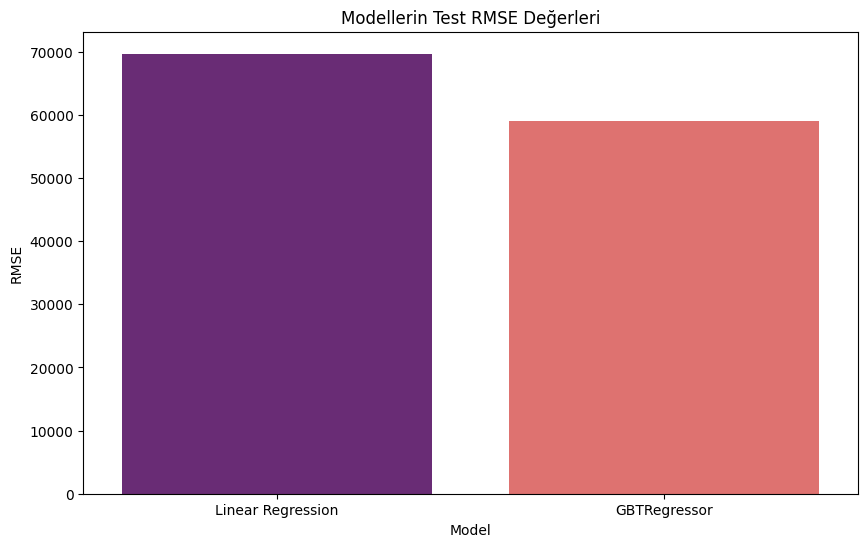

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Test RMSE", data=results, palette="magma")
plt.title("Modellerin Test RMSE Değerleri")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.show()

Aşağıdaki grafik, GBTRegressor'un Linear Regression'a kıyasla daha yüksek test R² değerine sahip olduğunu göstermektedir.

Bu, GBTRegressor'un test veri setindeki varyansı daha iyi açıkladığını ve daha başarılı bir model olduğunu ortaya koymaktadır.

<ipython-input-21-43e706feec4a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Test R²", data=results, palette="magma")


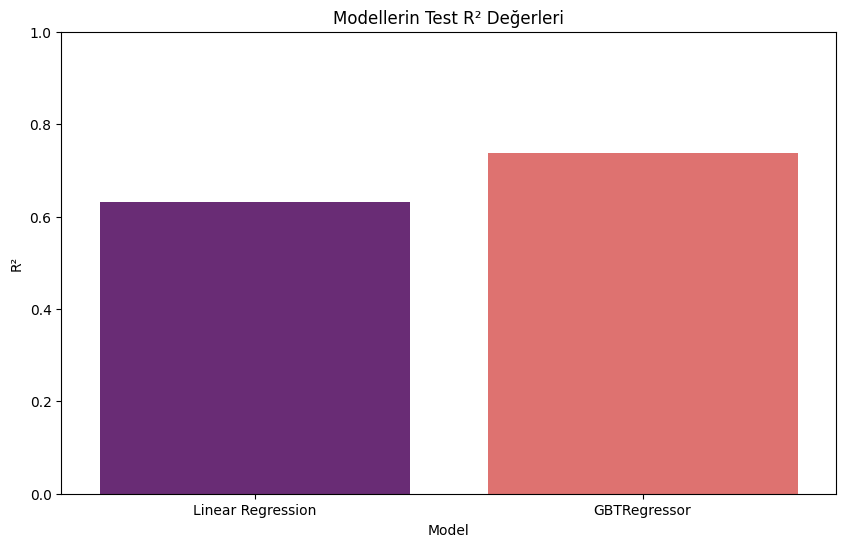

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Test R²", data=results, palette="magma")
plt.title("Modellerin Test R² Değerleri")
plt.ylabel("R²")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.show()

Grafik, GBTRegressor'un hem eğitim hem de test veri setlerinde Linear Regression'a kıyasla daha düşük RMSE değerlerine sahip olduğunu göstermektedir.

Bu, GBTRegressor'un her iki veri setinde de daha doğru tahminler yaptığını ortaya koymaktadır.

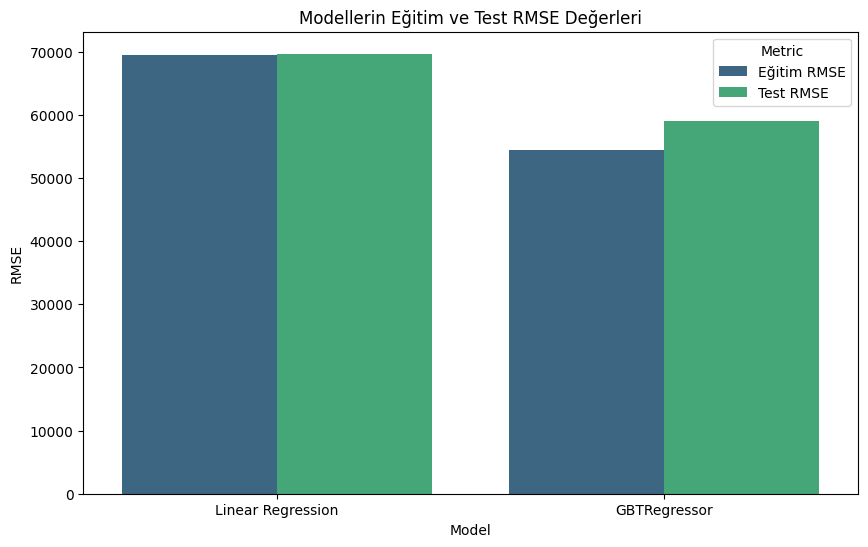

In [ ]:
rmse_df = results.melt(id_vars=["Model"], value_vars=["Eğitim RMSE", "Test RMSE"],
                       var_name="Metric", value_name="RMSE")

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="RMSE", hue="Metric", data=rmse_df, palette="viridis")
plt.title("Modellerin Eğitim ve Test RMSE Değerleri")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.legend(title="Metric")
plt.show()

Grafik, GBTRegressor'un hem eğitim hem de test veri setlerinde Linear Regression'a kıyasla daha yüksek R² değerlerine sahip olduğunu göstermektedir.

Bu, GBTRegressor'un her iki veri setindeki varyansı daha iyi açıkladığını ve daha başarılı bir model olduğunu ortaya koymaktadır.

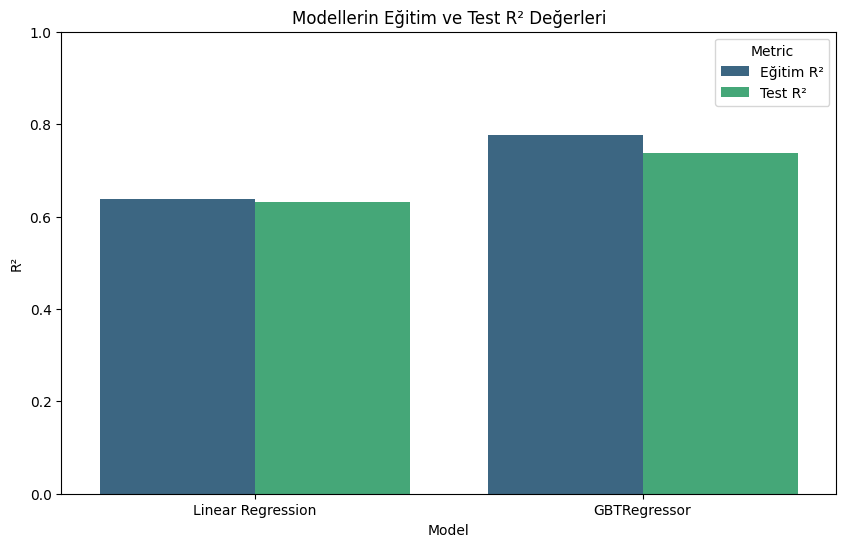

In [ ]:
r2_df = results.melt(id_vars=["Model"], value_vars=["Eğitim R²", "Test R²"],
                     var_name="Metric", value_name="R²")

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="R²", hue="Metric", data=r2_df, palette="viridis")
plt.title("Modellerin Eğitim ve Test R² Değerleri")
plt.ylabel("R²")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.legend(title="Metric")
plt.show()

Grafikler, GBTRegressor modelinin Linear Regression'a kıyasla daha düşük RMSE ve daha yüksek R² değerlerine sahip olduğunu göstermektedir.

Bu sonuçlar, GBTRegressor'un veri setindeki karmaşık ilişkileri daha iyi modelleyebildiğini ortaya koymaktadır.

Son olarak SparkSession kapatılır.

In [ ]:
spark.stop()